In [1]:
# === SEKCJA 1: IMPORT I KONFIGURACJA ===
import pandas as pd
import numpy as np
import re
import warnings

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import display
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

print("Wczytywanie danych...")
df_main = pd.read_csv('data.csv', sep=',', low_memory=False)
df_ulic = pd.read_csv('Ulic.csv', sep=',')
print("Wszystkie pliki wczytane.")

Wczytywanie danych...
Wszystkie pliki wczytane.


In [2]:
# === SEKCJA 2: PRZYGOTOWANIE DANYCH ===
df_ulic.rename(columns={'Name': 'NAZWA_ULICY'}, inplace=True)
df_ulic.dropna(subset=['SymUl', 'NAZWA_ULICY'], inplace=True)
street_dictionary = pd.Series(df_ulic.NAZWA_ULICY.values, index=df_ulic.SymUl).to_dict()

df_processed = df_main.copy()
df_processed.dropna(subset=['Area', 'Price', 'Description', 'Location', 'StreetNumber'], inplace=True)

def process_location(row):
    location_str, district, street = row['Location'], np.nan, np.nan
    if isinstance(location_str, str):
        parts = [p.strip() for p in location_str.split(',')]
        if len(parts) >= 3 and 'warszawa' in parts[1].lower(): district = parts[2]
    if pd.notna(row['StreetNumber']):
        try:
            street_sym = int(row['StreetNumber'])
            if street_sym in street_dictionary: street = street_dictionary[street_sym]
        except (ValueError, TypeError): pass
    if pd.isna(street) and isinstance(location_str, str) and len(location_str.split(',')) >= 4:
        street = location_str.split(',')[3].strip()
    if isinstance(street, str):
        street = re.sub(r'^(ul\\.|al\\.|pl\\.)\\s*', '', street, flags=re.IGNORECASE).lower()
        if len(street) < 3: street = np.nan
    return pd.Series([district, street])

df_processed[['District', 'Ulica_clean']] = df_processed.apply(process_location, axis=1)
df_processed.dropna(subset=['Ulica_clean', 'District'], inplace=True)

MIN_SAMPLES_PER_STREET = 25
street_counts = df_processed['Ulica_clean'].value_counts()
streets_to_remove = street_counts[street_counts < MIN_SAMPLES_PER_STREET].index
df_model_ready = df_processed[~df_processed['Ulica_clean'].isin(streets_to_remove)].copy()
print(f"Finalny zbiór danych gotowy. Wiersze: {len(df_model_ready)}, Ulice: {df_model_ready['Ulica_clean'].nunique()}")

Finalny zbiór danych gotowy. Wiersze: 52543, Ulice: 682


In [3]:
# === SEKCJA 3: INŻYNIERIA CECH DO SIECI NEURONOWEJ ===

# ZMIANA: Powrót do prostej funkcji czyszczącej, bez lematyzacji
def clean_text(text): return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df_model_ready['description_clean'] = df_model_ready['Description'].apply(clean_text)

# Funkcja do ekstrakcji kontekstu zabudowy (zostaje, bo jest bardzo pomocna)
def get_building_context(description):
    desc = str(description).lower()
    if any(word in desc for word in ['kamienica', 'przedwojenna', 'cegły', 'historyczna']):
        return 'kamienica'
    if any(word in desc for word in ['blok', 'wielka płyta', 'wieżowiec', 'płyt', 'blokowisko']):
        return 'blok'
    if any(word in desc for word in ['apartamentowiec', 'nowe budownictwo', 'nowy budynek', 'inwestycja', 'developerski']):
        return 'apartamentowiec'
    if any(word in desc for word in ['dom', 'szeregowiec', 'bliźniak', 'segment']):
        return 'dom'
    return 'inny'

df_model_ready['BuildingContext'] = df_model_ready['Description'].apply(get_building_context)

MAX_WORDS, MAX_LEN = 20000, 200
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_model_ready['description_clean'])
sequences = tokenizer.texts_to_sequences(df_model_ready['description_clean'])
X_text = pad_sequences(sequences, maxlen=MAX_LEN)

numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = numeric_pipeline.fit_transform(df_model_ready[numeric_features])

categorical_features = ['District', 'BuildingType', 'BuildingContext']
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
X_categorical = cat_pipeline.fit_transform(df_model_ready[categorical_features])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_model_ready['Ulica_clean'])
num_classes = len(label_encoder.classes_)
print("Dane przygotowane do treningu.")

Dane przygotowane do treningu.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 200, 128)          │       2,560,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 256)               │         263,168 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, 42)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 303)               │               0 │ bidirectional[0][0],       │
│                               │                           │                 │ numeric_input[0][0],       │
│                               │                           │                 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │         155,648 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         131,328 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256)               │           1,024 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 682)               │         175,274 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,288,490 (12.54 MB)

 Trainable params: 3,286,954 (12.54 MB)

 Non-trainable params: 1,536 (6.00 KB)


Rozpoczynam trening sieci neuronowej (wersja z regularyzacją LSTM)...
Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 656s 4s/step - accuracy: 0.0710 - loss: 5.7138 - val_accuracy: 0.1273 - val_loss: 5.5072 - learning_rate: 0.0010
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 672s 4s/step - accuracy: 0.1693 - loss: 3.5665 - val_accuracy: 0.1867 - val_loss: 4.3320 - learning_rate: 0.0010
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 668s 4s/step - accuracy: 0.2071 - loss: 3.2629 - val_accuracy: 0.2461 - val_loss: 3.3294 - learning_rate: 0.0010
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 661s 4s/step - accuracy: 0.2564 - loss: 2.9912 - val_accuracy: 0.2782 - val_loss: 2.9605 - learning_rate: 0.0010
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.2942 - loss: 2.7997 - val_accuracy: 0.3083 - val_loss: 2.7804 - learning_rate: 0.0010
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 654s 4s/step - accuracy: 0.3392 - loss: 2.5821 - val_accuracy: 0.3283 - val_loss: 2.6838 - learning_rate: 0.0010
Epoch 7/20


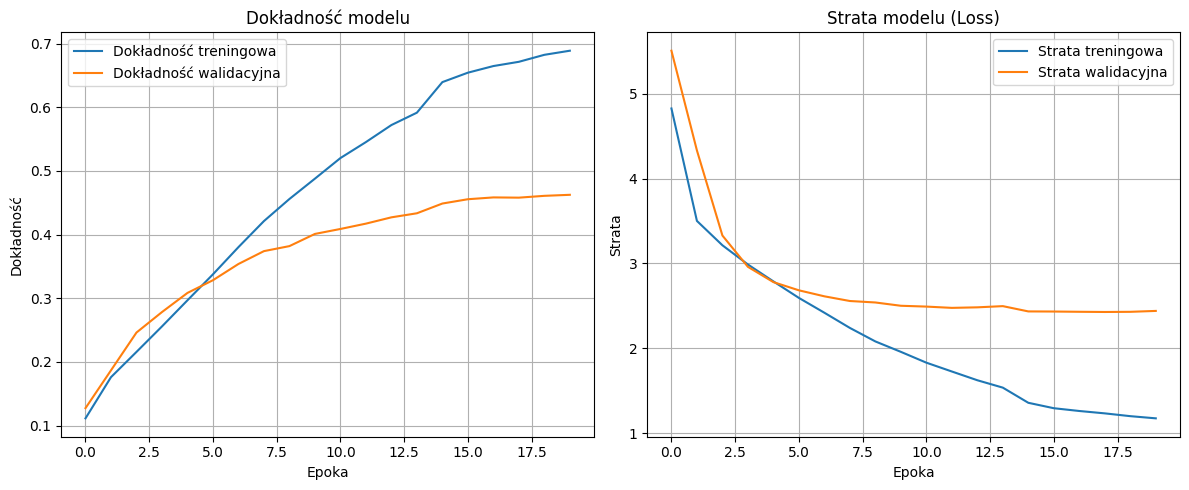

In [4]:
# === SEKCJA 4: BUDOWA I TRENING - WERSJA Z REGULARYZACJĄ LSTM ===

# Definicja architektury z regularyzacją warstwy LSTM
input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
input_categorical = Input(shape=(X_categorical.shape[1],), name='categorical_input')

embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=128)(input_text)
# ZMIANA: Dodanie recurrent_dropout, najskuteczniejszej regularyzacji dla LSTM
lstm_layer = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3))(embedding_layer)
concatenated = Concatenate()([lstm_layer, input_numeric, input_categorical])

x = Dense(512, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input_text, input_numeric, input_categorical], outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Podział i trening
X_train_text, X_val_text, X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_text, X_numeric, X_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ZMIANA: Zwiększenie patience do 4, aby dać modelowi więcej czasu na naukę
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

print("\nRozpoczynam trening sieci neuronowej (wersja z regularyzacją LSTM)...")
history = model.fit(
    [X_train_text, X_train_num, X_train_cat], y_train,
    validation_data=([X_val_text, X_val_num, X_val_cat], y_val),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr]
)

model.save('street_predictor_final_v5.keras')
print("\nModel został wytrenowany i zapisany jako 'street_predictor_final_v5.keras'.")

# Wizualizacja
print("\nGenerowanie wykresów uczenia...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# === SEKCJA 5: PREDYKCJA NA CAŁEJ BAZIE I WZBOGACENIE DANYCH ===

print("Przygotowywanie całego zbioru danych do predykcji...")

df_predict_base = df_main.copy()

# Stosowanie tych samych transformacji, co na zbiorze treningowym
df_predict_base[['District', 'Ulica_clean']] = df_predict_base.apply(process_location, axis=1)
df_predict_base['description_clean'] = df_predict_base['Description'].apply(clean_text)
df_predict_base['BuildingContext'] = df_predict_base['Description'].apply(get_building_context)

# Wypełnienie braków
df_predict_base['description_clean'].fillna('brak opisu', inplace=True)
for col in numeric_features:
    df_predict_base[col].fillna(0, inplace=True)
for col in categorical_features:
    df_predict_base[col].fillna('missing', inplace=True)

# Transformacja danych
sequences_pred = tokenizer.texts_to_sequences(df_predict_base['description_clean'])
X_text_full = pad_sequences(sequences_pred, maxlen=MAX_LEN)
X_numeric_full = numeric_pipeline.transform(df_predict_base[numeric_features])
X_categorical_full = cat_pipeline.transform(df_predict_base[categorical_features])

print("Generowanie predykcji dla całego zbioru danych...")
predictions_proba = model.predict([X_text_full, X_numeric_full, X_categorical_full])
predicted_labels_encoded = np.argmax(predictions_proba, axis=1)
predicted_street_names = label_encoder.inverse_transform(predicted_labels_encoded)
predicted_probabilities = np.max(predictions_proba, axis=1)

df_predict_base['Predicted_Ulica'] = predicted_street_names
df_predict_base['Predicted_Ulica_Prob'] = predicted_probabilities

print("Predykcja zakończona. Dane zostały wzbogacone.")

Przygotowywanie całego zbioru danych do predykcji...
Generowanie predykcji dla całego zbioru danych...
6133/6133 ━━━━━━━━━━━━━━━━━━━━ 1822s 297ms/step
Predykcja zakończona. Dane zostały wzbogacone.


In [6]:
# === SEKCJA 6: WERYFIKACJA I KOREKTA PREDYKCJI (WERSJA POPRAWIONA) ===

print("Tworzenie mapy ulica -> dzielnica na podstawie danych treningowych...")
# Używamy df_model_ready, bo zawiera tylko te ulice i dzielnice, na których model był uczony
street_to_district_map = df_model_ready.drop_duplicates(subset='Ulica_clean').set_index('Ulica_clean')['District'].to_dict()

# --- Korekta predykcji ---
print("Weryfikacja i korekta predykcji w oparciu o dzielnicę...")

# Pobierz top 3 predykcje i ich prawdopodobieństwa
top_k = 3
top_k_indices = np.argsort(predictions_proba, axis=1)[:, -top_k:]
top_k_probs = np.sort(predictions_proba, axis=1)[:, -top_k:]

corrected_streets = []
corrected_probs = []
correction_counter = 0

for i in range(len(df_predict_base)):
    original_district = df_predict_base.loc[i, 'District']
    is_corrected = False
    
    # Sprawdzamy predykcje od najlepszej do najgorszej (w ramach top_k)
    for j in range(top_k - 1, -1, -1):
        pred_street_idx = top_k_indices[i, j]
        pred_street_name = label_encoder.classes_[pred_street_idx]
        pred_street_district = street_to_district_map.get(pred_street_name)

        # Jeśli dzielnica jest znana i zgadza się z oryginalną, akceptujemy tę predykcję
        if pd.notna(original_district) and original_district != 'missing' and original_district == pred_street_district:
            corrected_streets.append(pred_street_name)
            corrected_probs.append(top_k_probs[i, j])
            if j < top_k - 1: # Jeśli nie była to pierwsza (najlepsza) predykcja
                correction_counter += 1
            is_corrected = True
            break
    
    # Jeśli żadna z top_k predykcji nie pasowała, bierzemy pierwotną (najlepszą)
    if not is_corrected:
        corrected_streets.append(df_predict_base.loc[i, 'Predicted_Ulica'])
        corrected_probs.append(df_predict_base.loc[i, 'Predicted_Ulica_Prob'])

# Zastąpienie starych predykcji nowymi, skorygowanymi
df_predict_base['Corrected_Ulica'] = corrected_streets
df_predict_base['Corrected_Ulica_Prob'] = corrected_probs

print(f"Liczba predykcji skorygowanych na podstawie dzielnicy: {correction_counter}")

# --- Ponowna weryfikacja po korekcie ---
df_predict_base['Corrected_Ulica_District'] = df_predict_base['Corrected_Ulica'].map(street_to_district_map)

# ZMIANA: Dodanie brakującej definicji funkcji verify_prediction
def verify_prediction(row):
    # Sprawdzamy tylko dla wierszy, gdzie mamy oryginalną dzielnicę (nie 'missing' lub NaN)
    if pd.notna(row['District']) and row['District'] != 'missing':
        # Porównujemy oryginalną dzielnicę z dzielnicą przypisaną do SKORYGOWANEJ ulicy
        if row['District'] == row['Corrected_Ulica_District']:
            return 'Zgodna'
        else:
            return 'Niezgodna'
    return 'Brak danych do weryfikacji'

df_predict_base['Prediction_Status'] = df_predict_base.apply(verify_prediction, axis=1)

# Wyświetlanie statystyk spójności
print("\nStatystyki spójności po korekcie:")
print(df_predict_base['Prediction_Status'].value_counts())

# Wyświetlanie przykładów niezgodnych predykcji (jak ta, którą znalazłeś)
print("\nPrzykładowe 10 losowych niezgodnych predykcji:")
display_cols_check = ['SaleId', 'Location', 'District', 'Corrected_Ulica', 'Corrected_Ulica_District', 'Corrected_Ulica_Prob', 'Description']
display(df_predict_base[df_predict_base['Prediction_Status'] == 'Niezgodna'][display_cols_check].sample(10, random_state=1))

# Wyświetlanie przykładowych wyników końcowych
print("\nPrzykładowe 25 losowych wierszy z uzupełnionymi i skorygowanymi danymi:")
display_cols = ['SaleId', 'Location', 'District', 'Corrected_Ulica', 'Corrected_Ulica_District', 'Prediction_Status', 'Corrected_Ulica_Prob', 'Price', 'Area']
display(df_predict_base[display_cols].sample(25, random_state=42))

# Zapis do pliku CSV
output_filename_corrected = 'data_with_corrected_streets.csv'
df_predict_base.to_csv(output_filename_corrected, index=False, sep=',')
print(f"\nFinalny DataFrame ({len(df_predict_base)} wierszy) zapisano do pliku: {output_filename_corrected}")

Tworzenie mapy ulica -> dzielnica na podstawie danych treningowych...
Weryfikacja i korekta predykcji w oparciu o dzielnicę...
Liczba predykcji skorygowanych na podstawie dzielnicy: 8198

Statystyki spójności po korekcie:
Prediction_Status
Zgodna                        129216
Brak danych do weryfikacji     66341
Niezgodna                        683
Name: count, dtype: int64

Przykładowe 10 losowych niezgodnych predykcji:


,SaleId,Location,District,Corrected_Ulica,Corrected_Ulica_District,Corrected_Ulica_Prob,Description
124024,3390985,"Mazowieckie, Warszawa, Wola, Ul. Łacińska",Wola,elektoralna,Śródmieście,0.333764,| Do sprzedaży bardzo funkcjonalne mieszkanie ...
4591,215575,"Mazowieckie, Warszawa, Wesoła, Stara Miłosna",Wesoła,poezji,Wawer,0.464690,"Mieszkanie 2-pokojowe, 46m2, wraz z ogródkiem ..."
43687,1775736,"Mazowieckie, Warszawa, Saska Kępa, Ul. Zwycięzców",Saska Kępa,zwycięzców,Praga-południe,0.206706,Oferuje mieszkanie z pięknym widokiem i rewela...
11272,518296,"Mazowieckie, Warszawa, Śródmieście",Śródmieście,syta,Wilanów,0.653048,Zapraszam do odkrycia wyjątkowej nieruchomości...
105507,3136978,"Mazowieckie, Warszawa, Wesoła",Wesoła,literacka,Bielany,0.392975,Oferta aktualna - możliwość umówienia bezpiecz...
168036,4096004,"Mazowieckie, Warszawa, Wola, Ul. Grzybowska",Wola,grzybowska,Śródmieście,0.993437,English below Okazja cenowa! Mieszkanie w oryg...
158326,3944282,"Mazowieckie, Warszawa, Śródmieście, Ul. Nowolipki",Śródmieście,nowolipki,Wola,0.916141,2 pokojowe mieszkanie ul. Nowolipki Śródmieści...
131458,3514547,"Mazowieckie, Warszawa, Wola",Wola,adama mickiewicza,Żoliborz,0.649764,MDP Partners prezentuje: 3 pokojowe mieszkanie...
176987,4215459,"Mazowieckie, Warszawa, Wesoła, Ul. Literacka",Wesoła,literacka,Bielany,0.996132,Pragnę zaoferować suterenę na poziomie -0.5 Lo...
142313,3697206,"Mazowieckie, Warszawa, Wola, Ul. Dzielna",Wola,dzielna,Śródmieście,0.974004,| Do sprzedaży małe mieszkanie na ulicy Dzieln...



Przykładowe 25 losowych wierszy z uzupełnionymi i skorygowanymi danymi:


,SaleId,Location,District,Corrected_Ulica,Corrected_Ulica_District,Prediction_Status,Corrected_Ulica_Prob,Price,Area
117971,3306651,"Mazowieckie, Warszawa, Mokotów, Ul. Polska",Mokotów,polska,Mokotów,Zgodna,0.996583,992250.0,55.90
105430,3136257,"Mazowieckie, Warszawa, Białołęka, Ul. Winorośli",Białołęka,pasłęcka,Białołęka,Zgodna,0.210100,0.0,50.00
130903,3506482,"Mazowieckie, Warszawa, Mokotów, Ksawerów",Mokotów,wołoska,Mokotów,Zgodna,0.595259,1904000.0,83.95
180140,4249856,"Mazowieckie, Grodziski, Grodzisk Mazowiecki",missing,loteryjki,Bielany,Brak danych do weryfikacji,0.131070,699000.0,55.00
73766,2760208,"Mazowieckie, Warszawa, Bemowo, Ul. Strońska",Bemowo,batalionów chłopskich,Bemowo,Zgodna,0.496253,850000.0,66.70
85493,2889192,"Mazowieckie, Radomski, Zakrzew, Bielicha",missing,podłużna,Białołęka,Brak danych do weryfikacji,0.139961,299000.0,67.50
19147,913358,"Mazowieckie, Warszawa, Ursus, Ul. Przy Forcie",Ursus,tomcia palucha,Ursus,Zgodna,0.553553,0.0,49.74
139381,3652415,"Mazowieckie, Warszawa, Praga-południe, Ul. Pol...",Praga-południe,gen. tadeusza bora-komorowskiego,Praga-południe,Zgodna,0.407522,865000.0,51.10
20811,954853,"Mazowieckie, Warszawa, Ursus, Ul. Szamoty",Ursus,herbu oksza,Ursus,Zgodna,0.443228,0.0,54.76
143413,3713496,"Mazowieckie, Legionowski, Legionowo, Ul. Husarska",missing,władysława broniewskiego,Bielany,Brak danych do weryfikacji,0.028645,525000.0,54.00



Finalny DataFrame (196240 wierszy) zapisano do pliku: data_with_corrected_streets.csv


In [7]:
# === SEKCJA 7: OBLICZENIE DOKŁADNOŚCI NA POZIOMIE DZIELNIC ===

print("Obliczanie dokładności predykcji na poziomie dzielnic (na zbiorze walidacyjnym)...")

# 1. Wykonaj predykcję na zbiorze walidacyjnym
y_pred_proba_val = model.predict([X_val_text, X_val_num, X_val_cat])
y_pred_encoded_val = np.argmax(y_pred_proba_val, axis=1)

# 2. Odkoduj przewidziane i prawdziwe NAZWY ULIC
predicted_streets_val = label_encoder.inverse_transform(y_pred_encoded_val)
true_streets_val = label_encoder.inverse_transform(y_val)

# 3. Zmapuj ulice na ich DZIELNICE
# Używamy tej samej mapy co w kroku weryfikacji
predicted_districts_val = [street_to_district_map.get(s, 'nieznana') for s in predicted_streets_val]
true_districts_val = [street_to_district_map.get(s, 'nieznana') for s in true_streets_val]

# 4. Oblicz dokładność
from sklearn.metrics import accuracy_score
district_accuracy = accuracy_score(true_districts_val, predicted_districts_val)

print(f"\nDokładność predykcji na poziomie ulic (val_accuracy): {history.history['val_accuracy'][-1]:.2%}")
print(f"Dokładność predykcji na poziomie dzielnic (obliczona): {district_accuracy:.2%}")

# Ta metryka pokazuje, jak często model, nawet jeśli pomyli się co do dokładnej ulicy,
# to i tak poprawnie wskazuje jej dzielnicę.

Obliczanie dokładności predykcji na poziomie dzielnic (na zbiorze walidacyjnym)...
329/329 ━━━━━━━━━━━━━━━━━━━━ 38s 114ms/step

Dokładność predykcji na poziomie ulic (val_accuracy): 46.25%
Dokładność predykcji na poziomie dzielnic (obliczona): 92.00%
